<a href="https://colab.research.google.com/github/Tarif-dev/ecg-ssl-research/blob/main/notebooks/02_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔧 Notebook 02: Preprocessing Pipeline

**Goal:** Apply signal processing to raw ECG data and save processed datasets for training.

**Pipeline:** Raw ECG → Bandpass filter (0.5–40 Hz) → Z-score normalization → Segmentation → Save

**Outputs:**
- `pretrain_segments.npy` — unlabeled 10-sec segments for self-supervised learning
- `finetune_beats.npy` + `finetune_labels.npy` — labeled heartbeats for fine-tuning

In [1]:
# ============================================================
# STEP 1: Setup (same as Notebook 01)
# ============================================================
!pip install -q wfdb numpy scipy matplotlib scikit-learn pyyaml tqdm

from google.colab import drive
drive.mount('/content/drive')

import os, sys
import numpy as np
import matplotlib.pyplot as plt

PROJECT_DIR = '/content/drive/MyDrive/ecg_ssl_research'
DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'raw', 'mitdb')
PROCESSED_DIR = os.path.join(PROJECT_DIR, 'data', 'processed')
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Setup imports from our repo
REPO_DIR = '/content/ecg-ssl-research'
if not os.path.exists(REPO_DIR):
    REPO_URL = "https://github.com/Tarif-dev/ecg-ssl-research.git"  # <-- CHANGE THIS
    !git clone {REPO_URL} {REPO_DIR}
else:
    !cd {REPO_DIR} && git pull

sys.path.insert(0, REPO_DIR)

from src.download_data import load_record, extract_beats, extract_segments, MITBIH_RECORDS
from src.data_loader import bandpass_filter, zscore_normalize, preprocess_signal
from src.utils import set_seed

set_seed(42)
print("✓ Setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 75.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 3.0.0 which is incompatible.
gradio 5.50.0 requires pandas<3.0,>=1.0, but you have pandas 3.0.0 which is incompatible.
bqplot 0.12.45 requires pandas<3.0.0,>=1.0.0, but you have pandas 3.0.0 which is incompatible.
db-dtypes 1.5.0 requires pandas<3.0.0,>=1.5.3, but you have pandas 3.0.0 which is incompatible.
Mounted at /content/drive
Cloning into '/content/ecg-ssl-research'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (30/30), done.
remote: T

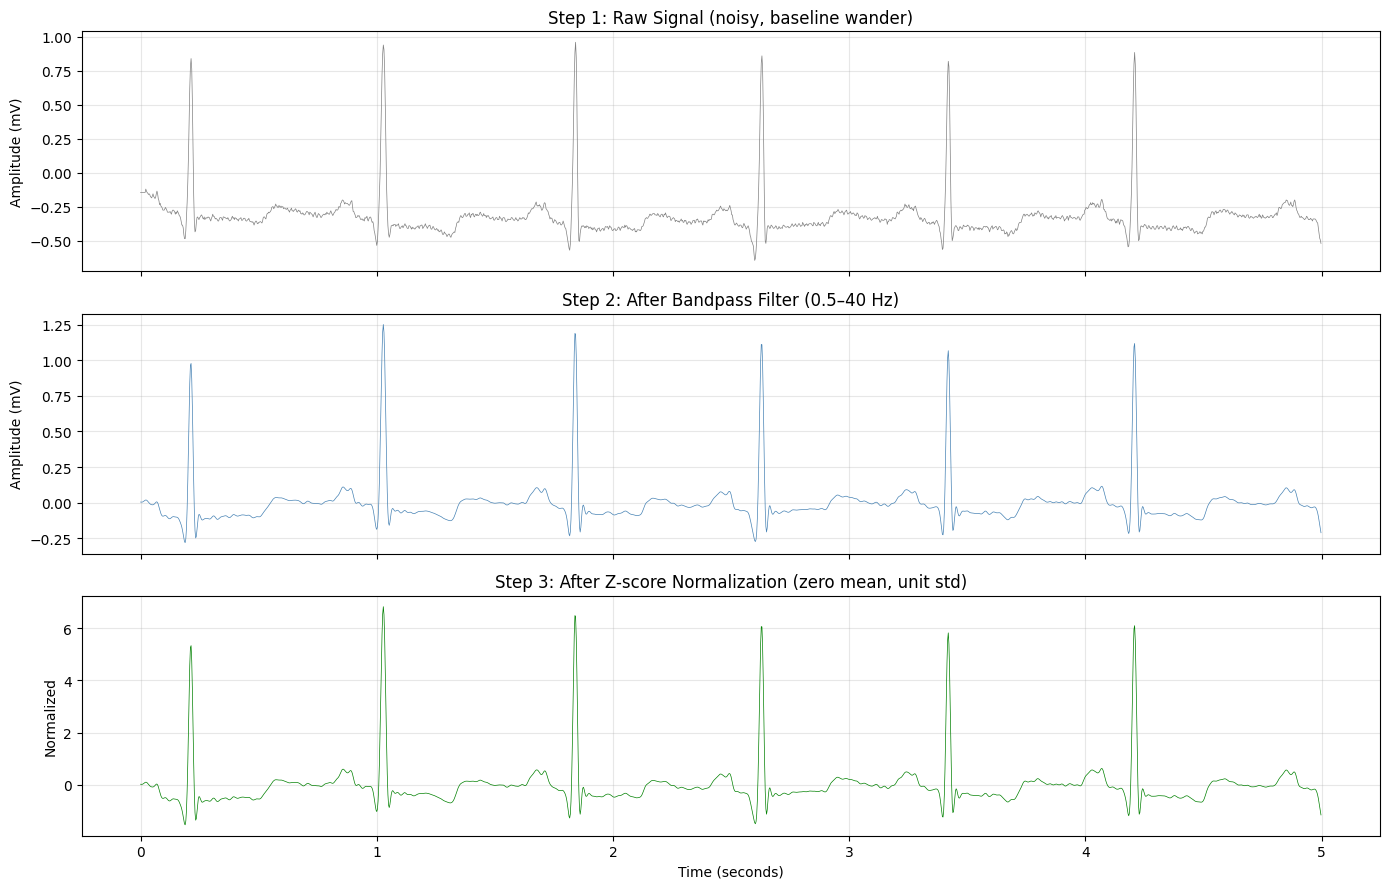

Raw stats:        mean=-0.320, std=0.165
Normalized stats: mean=-0.0225, std=0.8743


In [2]:
# ============================================================
# STEP 2: Visualize preprocessing effect on one record
# ============================================================

# Load record 100
rec_path = os.path.join(DATA_DIR, '100')
signal_raw, annotation, fs = load_record(rec_path, channel=0)

# Apply preprocessing steps individually to show the effect
signal_filtered = bandpass_filter(signal_raw, fs, lowcut=0.5, highcut=40.0)
signal_normalized = zscore_normalize(signal_filtered)

# Plot: Raw vs Filtered vs Normalized (5-second window)
duration = 5  # seconds
n_samples = int(duration * fs)
time_axis = np.arange(n_samples) / fs

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

axes[0].plot(time_axis, signal_raw[:n_samples], color='gray', lw=0.5)
axes[0].set_title('Step 1: Raw Signal (noisy, baseline wander)')
axes[0].set_ylabel('Amplitude (mV)')

axes[1].plot(time_axis, signal_filtered[:n_samples], color='steelblue', lw=0.5)
axes[1].set_title('Step 2: After Bandpass Filter (0.5–40 Hz)')
axes[1].set_ylabel('Amplitude (mV)')

axes[2].plot(time_axis, signal_normalized[:n_samples], color='green', lw=0.5)
axes[2].set_title('Step 3: After Z-score Normalization (zero mean, unit std)')
axes[2].set_ylabel('Normalized')
axes[2].set_xlabel('Time (seconds)')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'preprocessing_demo.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f"Raw stats:        mean={signal_raw[:n_samples].mean():.3f}, std={signal_raw[:n_samples].std():.3f}")
print(f"Normalized stats: mean={signal_normalized[:n_samples].mean():.4f}, std={signal_normalized[:n_samples].std():.4f}")

In [3]:
# ============================================================
# STEP 3: Process ALL records — create pre-training segments
# ============================================================
# This creates 10-second overlapping segments from all 48 records
# These segments are UNLABELED — used for self-supervised pre-training

from tqdm import tqdm

all_segments = []
segment_duration = 10  # seconds
overlap = 0.75         # 75% overlap

print("Processing all records for pre-training segments...\n")

for rec_id in tqdm(MITBIH_RECORDS, desc="Records"):
    try:
        rec_path = os.path.join(DATA_DIR, str(rec_id))
        signal, _, rec_fs = load_record(rec_path, channel=0)

        # Preprocess: filter + normalize
        processed = preprocess_signal(signal, rec_fs)

        # Extract 10-second overlapping segments
        segments = extract_segments(processed, rec_fs, segment_duration, overlap)
        all_segments.append(segments)

    except Exception as e:
        print(f"  ⚠ Record {rec_id} failed: {e}")

# Combine all segments
pretrain_segments = np.concatenate(all_segments, axis=0)
print(f"\n✓ Pre-training segments: {pretrain_segments.shape}")
print(f"  Total segments: {len(pretrain_segments):,}")
print(f"  Segment length: {pretrain_segments.shape[1]} samples "
      f"({pretrain_segments.shape[1]/360:.1f}s @ 360 Hz)")
print(f"  Memory: {pretrain_segments.nbytes / 1e6:.1f} MB")

Processing all records for pre-training segments...



Records: 100%|██████████| 48/48 [01:19<00:00,  1.65s/it]



✓ Pre-training segments: (34512, 3600)
  Total segments: 34,512
  Segment length: 3600 samples (10.0s @ 360 Hz)
  Memory: 497.0 MB


In [4]:
# ============================================================
# STEP 4: Extract labeled beats for fine-tuning
# ============================================================
# Individual heartbeats centered on R-peaks, with Normal/Arrhythmia labels

all_beats = []
all_labels = []

print("Extracting labeled beats for fine-tuning...\n")

for rec_id in tqdm(MITBIH_RECORDS, desc="Records"):
    try:
        rec_path = os.path.join(DATA_DIR, str(rec_id))
        signal, annotation, rec_fs = load_record(rec_path, channel=0)

        # Preprocess
        processed = preprocess_signal(signal, rec_fs)

        # Extract beats (0.3s before + 0.5s after R-peak = 288 samples @ 360Hz)
        beats, labels = extract_beats(processed, annotation, rec_fs)

        if len(beats) > 0:
            all_beats.append(beats)
            all_labels.append(labels)
    except Exception as e:
        print(f"  ⚠ Record {rec_id}: {e}")

finetune_beats = np.concatenate(all_beats, axis=0)
finetune_labels = np.concatenate(all_labels, axis=0)

print(f"\n✓ Fine-tuning beats: {finetune_beats.shape}")
print(f"  Beat length: {finetune_beats.shape[1]} samples "
      f"({finetune_beats.shape[1]/360*1000:.0f} ms)")
print(f"  Normal (0): {(finetune_labels == 0).sum():,}")
print(f"  Arrhythmia (1): {(finetune_labels == 1).sum():,}")
print(f"  Imbalance ratio: 1:{(finetune_labels==0).sum() / max(1,(finetune_labels==1).sum()):.1f}")

Extracting labeled beats for fine-tuning...



Records: 100%|██████████| 48/48 [00:06<00:00,  7.06it/s]


✓ Fine-tuning beats: (109448, 288)
  Beat length: 288 samples (800 ms)
  Normal (0): 90,591
  Arrhythmia (1): 18,857
  Imbalance ratio: 1:4.8


✓ Saved: /content/drive/MyDrive/ecg_ssl_research/data/processed/pretrain_segments.npy
  Shape: (34512, 3600), Size: 497.0 MB
✓ Saved: /content/drive/MyDrive/ecg_ssl_research/data/processed/finetune_beats.npy
  Shape: (109448, 288)
✓ Saved: /content/drive/MyDrive/ecg_ssl_research/data/processed/finetune_labels.npy
  Shape: (109448,)


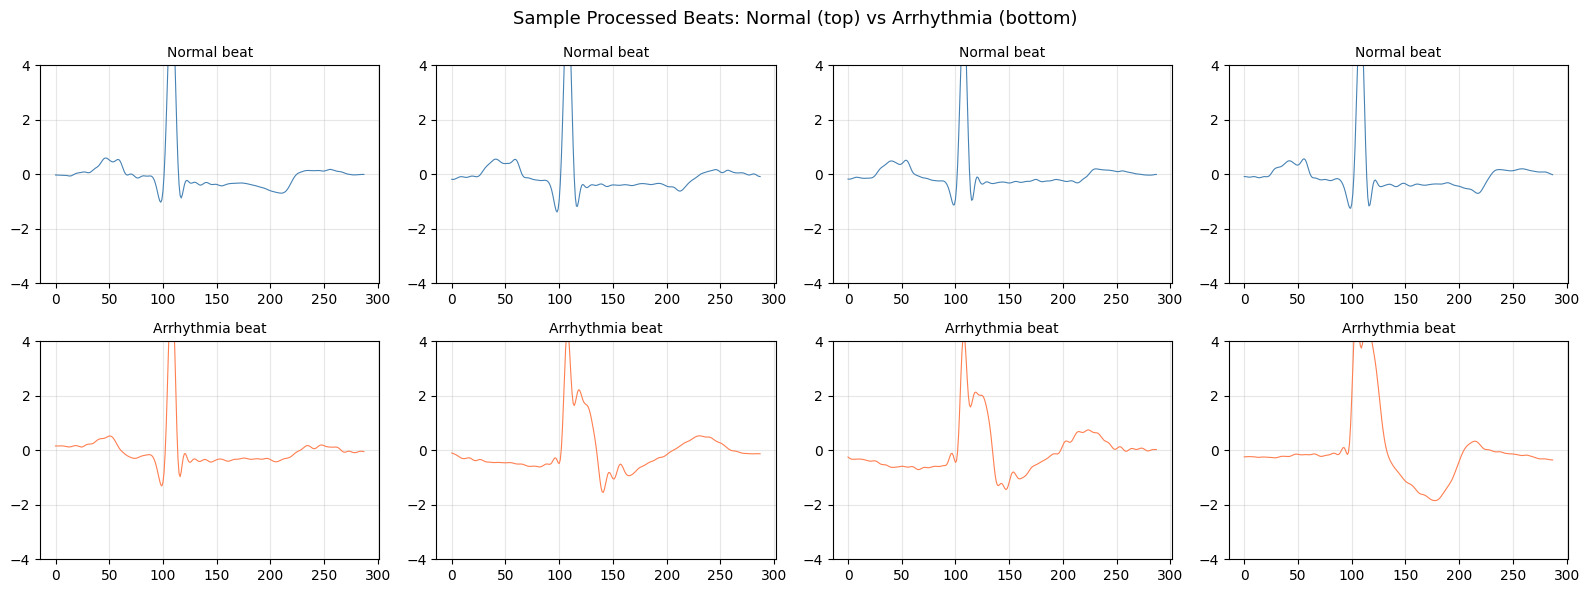


✓ Preprocessing complete! Proceed to Notebook 03 for pre-training.


In [5]:
# ============================================================
# STEP 5: Save processed data to Google Drive
# ============================================================
# Saved to Drive so you DON'T need to reprocess next time!

# Pre-training segments (unlabeled)
pretrain_path = os.path.join(PROCESSED_DIR, 'pretrain_segments.npy')
np.save(pretrain_path, pretrain_segments)
print(f"✓ Saved: {pretrain_path}")
print(f"  Shape: {pretrain_segments.shape}, Size: {os.path.getsize(pretrain_path)/1e6:.1f} MB")

# Fine-tuning beats + labels
beats_path = os.path.join(PROCESSED_DIR, 'finetune_beats.npy')
labels_path = os.path.join(PROCESSED_DIR, 'finetune_labels.npy')
np.save(beats_path, finetune_beats)
np.save(labels_path, finetune_labels)
print(f"✓ Saved: {beats_path}")
print(f"  Shape: {finetune_beats.shape}")
print(f"✓ Saved: {labels_path}")
print(f"  Shape: {finetune_labels.shape}")

# Quick visualization of a few beats
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for i, ax in enumerate(axes[0]):
    idx = np.where(finetune_labels == 0)[0][i*100]  # Normal beats
    ax.plot(finetune_beats[idx], color='steelblue', lw=0.8)
    ax.set_title(f'Normal beat', fontsize=10)
    ax.set_ylim(-4, 4)
    ax.grid(True, alpha=0.3)

for i, ax in enumerate(axes[1]):
    idx = np.where(finetune_labels == 1)[0][i*50]  # Arrhythmia beats
    ax.plot(finetune_beats[idx], color='coral', lw=0.8)
    ax.set_title(f'Arrhythmia beat', fontsize=10)
    ax.set_ylim(-4, 4)
    ax.grid(True, alpha=0.3)

fig.suptitle('Sample Processed Beats: Normal (top) vs Arrhythmia (bottom)', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_DIR, 'sample_beats.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Preprocessing complete! Proceed to Notebook 03 for pre-training.")